In [499]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import skew
from sklearn.preprocessing import normalize

%matplotlib inline

In [500]:
training_data = pd.DataFrame.from_csv('train.csv')
test_data = pd.DataFrame.from_csv('test.csv')

In [501]:
data = pd.concat([training_data, test_data])

In [502]:
data = pd.get_dummies(data)

In [503]:
for c in data.columns:
    num_nulls = len(data[data[c].isnull()])
    if num_nulls != 0:
        print('Feature {} type {} has {} null values, accounts for {}% data set'.format(
                c, data[c].dtypes, num_nulls, round(100 * num_nulls / len(data),2 )))

Feature BsmtFinSF1 type float64 has 1 null values, accounts for 0.03% data set
Feature BsmtFinSF2 type float64 has 1 null values, accounts for 0.03% data set
Feature BsmtFullBath type float64 has 2 null values, accounts for 0.07% data set
Feature BsmtHalfBath type float64 has 2 null values, accounts for 0.07% data set
Feature BsmtUnfSF type float64 has 1 null values, accounts for 0.03% data set
Feature GarageArea type float64 has 1 null values, accounts for 0.03% data set
Feature GarageCars type float64 has 1 null values, accounts for 0.03% data set
Feature GarageYrBlt type float64 has 159 null values, accounts for 5.45% data set
Feature LotFrontage type float64 has 486 null values, accounts for 16.65% data set
Feature MasVnrArea type float64 has 23 null values, accounts for 0.79% data set
Feature SalePrice type float64 has 1459 null values, accounts for 49.98% data set
Feature TotalBsmtSF type float64 has 1 null values, accounts for 0.03% data set


In [504]:
data = data.fillna(data.mean())

In [505]:
features = data.columns.values.tolist()
features.remove('SalePrice')

In [506]:
X_train = data[:len(training_data)][features]
X_test = data[len(training_data):][features]
y = data[:len(training_data)]['SalePrice']

In [507]:
# Feature selection
coefs = []
for l1_penalty in [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]:
    error = np.sqrt(-cross_val_score(linear_model.Lasso(alpha=l1_penalty, normalize=True, max_iter=100000), X_train, y, scoring="neg_mean_squared_error", cv=5)).mean()
    coefs.append(tuple((l1_penalty, error)))

In [508]:
alphas = [x[0] for x in coefs]
errors = [x[1] for x in coefs]

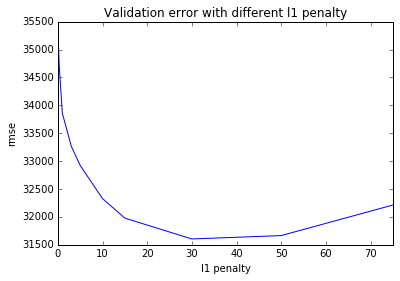

In [509]:
errors = pd.Series(errors, index=alphas)
errors.plot(title='Validation error with different l1 penalty')
plt.xlabel('l1 penalty')
plt.ylabel('rmse')

In [223]:
# Best penalty = 30

In [510]:
model = linear_model.Lasso(alpha=30, normalize=True)
model.fit(X_train, y)

Lasso(alpha=30, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [511]:
coef = pd.Series(model.coef_, index = features)

In [512]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 68 variables and eliminated the other 220 variables


In [513]:
imp_coef = pd.concat([coef.sort_values().head(10),
                      coef.sort_values().tail(10)])

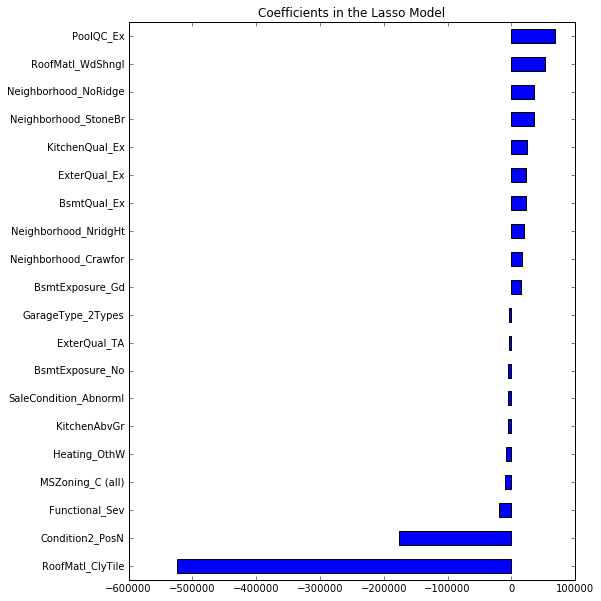

In [514]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [515]:
important_features = [features[i] for i in np.where(model.coef_ != 0)[0]]

In [516]:
important_features

['BsmtFinSF1',
 'BsmtFullBath',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenAbvGr',
 'LotArea',
 'LowQualFinSF',
 'MSSubClass',
 'MasVnrArea',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'ScreenPorch',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'BldgType_1Fam',
 'BsmtCond_Fa',
 'BsmtExposure_Gd',
 'BsmtExposure_No',
 'BsmtFinType1_GLQ',
 'BsmtFinType2_ALQ',
 'BsmtQual_Ex',
 'BsmtQual_TA',
 'Condition1_Artery',
 'Condition1_Norm',
 'Condition1_RRAe',
 'Condition2_PosN',
 'ExterQual_Ex',
 'ExterQual_TA',
 'Exterior1st_BrkFace',
 'Foundation_PConc',
 'Functional_Sev',
 'Functional_Typ',
 'GarageFinish_Fin',
 'GarageQual_Ex',
 'GarageType_2Types',
 'Heating_OthW',
 'HeatingQC_Ex',
 'KitchenQual_Ex',
 'KitchenQual_TA',
 'LandContour_Bnk',
 'LotConfig_CulDSac',
 'LotShape_IR2',
 'MSZoning_C (all)',
 'MSZoning_RM',
 'Neighborhood_BrkSide',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Mitchel',
 'Nei